In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import tqdm

In [2]:
import plotkm #You should leave this out; it's only so I get plots that fit the style of my blog.

If we have training data, then it's relatively simple to use PyTorch to optimize.  Take for example find the three mystery parameters to reconstruct this quadratic function: 

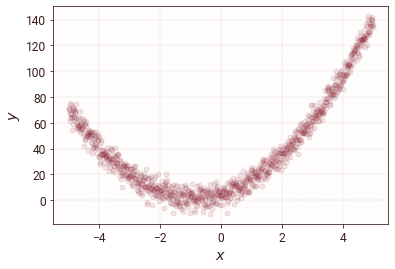

In [3]:
#Seed the random number generator so you get the same parameters as I did:
np.random.seed(0)
A_true, B_true, C_true = np.random.randint(0,8,3)
     
x_data = np.linspace(-5, 5, num=1000)
y_data = A_true*x_data**2 + B_true*x_data + C_true + np.random.normal(0, 5, x_data.shape)

plt.scatter(x_data, y_data, alpha=0.1)
plt.ylabel("$y$")
plt.xlabel("$x$")
plt.show()

In [4]:
class Quadratic(torch.nn.Module):
    def __init__(self):
        super().__init__()
        #initialize params (which will be a single variable) to a zero-vector
        self.params = torch.nn.Parameter(torch.Tensor([0,0,0]))
        
    def forward(self, x):
        a, b, c = self.params
        return a*x**2 + b*x + c

In [5]:
def iteration(model, optimizer, x_data, y_data, n=10000):
    losses = np.zeros(n)
    params = np.zeros((n,3))
    for i in tqdm.tqdm(range(n)):
        y_pred = model(x_data)
        loss = torch.functional.F.mse_loss(y_pred, y_data).sqrt()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses[i] = loss.detach().numpy()
        params[i,:] = model.params.detach().numpy()
    return np.array(losses), np.array(params)

In [6]:
Q = Quadratic()
x_data = torch.Tensor(x_data)
y_data = torch.Tensor(y_data)

optimizer = torch.optim.Adam(Q.parameters(), lr=0.001)
losses, params = iteration(Q, optimizer, x_data, y_data)




100%|███████████████████████████████████| 10000/10000 [00:03<00:00, 2526.68it/s]


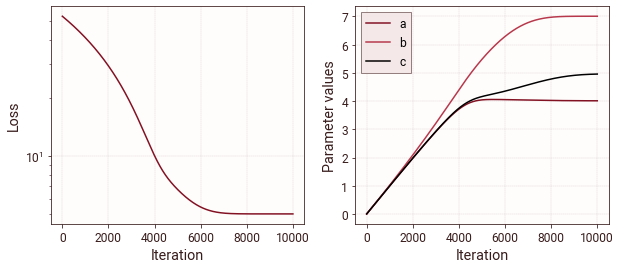

In [7]:
fig, axs = plt.subplots(1,2,figsize=(10,4))
axs[0].semilogy(losses)
axs[0].set_ylabel("Loss")
axs[0].set_xlabel("Iteration")

axs[1].plot(params[:,0], label="a")
axs[1].plot(params[:,1], label="b")
axs[1].plot(params[:,2], label="c")
axs[1].set_ylabel("Parameter values")
axs[1].set_xlabel("Iteration")
axs[1].legend()
fig.show()

Learned parameters: A=4.010000228881836, B=7.010000228881836, C=4.960000038146973
Mysterious true parameters: A=4, B=7, C=5


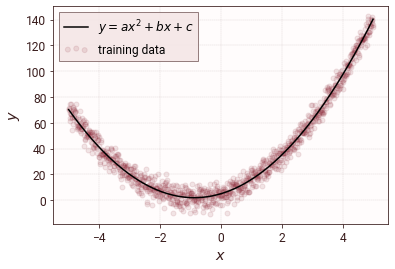

In [8]:
A_learned, B_learned, C_learned = Q.params.detach().numpy()

print(f"Learned parameters: A={round(A_learned,2)}, B={round(B_learned,2)}, C={round(C_learned,2)}")
print(f"Mysterious true parameters: A={A_true}, B={B_true}, C={C_true}")

plt.scatter(x_data, y_data, alpha=0.1, label="training data")
plt.plot(x_data, A_learned*x_data**2 + B_learned*x_data + C_learned, 'k', label=r"$y=ax^2 + bx + c$")
plt.ylabel("$y$")
plt.xlabel("$x$")
plt.legend()
plt.show()


# Finite difference

/home/kmills/anaconda3/envs/cim/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


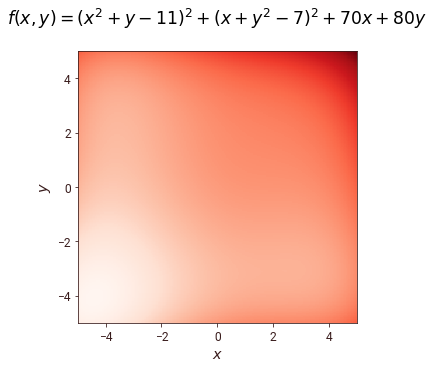

In [9]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import tqdm


def cost_function(params):
    x,y = params
    f = (x**2 + y - 11)**2 + (x + y**2 -7)**2 + 70*x + 80*y
    return f

mesh = np.meshgrid(np.linspace(-5,5, num=200), np.linspace(-5,5, num=200))
surface = cost_function(mesh)
fig, axs = plt.subplots(1,1, figsize=(5,5))
axs.set_xlabel("$x$")
axs.set_ylabel("$y$")
axs.set_title("$f(x,y) = (x^2 + y - 11)^2 + (x + y^2 -7)^2 + 70x + 80y$\n")
axs.pcolormesh(*mesh, surface)

In [10]:
class FiniteDifference(torch.autograd.Function):
    @staticmethod
    def forward(self, params):
        #Forward takes in parameters and returns the value of the cost function
        #evaluated at these parameters.
        #Both the parameters and the value will be cached in self.* so that
        #they are available in the backward pass
        self.params = params
        with torch.no_grad():
            self.f_x = cost_function(params)
        return self.f_x

    # We need to write our own function to set the gradients for the
    # backward pass. For example, if we have two parameters:
    # grad_a(F) = F(a+epsilon, b) - F(a, b).
    # grad_b(F) = F(a, b+epsilon) - F(a, b).
    # The last term in each of these is the forward pass value we cached in self.f_x.
    # We must evaluate the training function for each of these three perturbations. 
    
    @staticmethod
    def backward(self, g):
        eps = 0.0001
        
        grads = []
        #loop over params
        for i in range(len(self.params)):
            perturb = torch.clone(self.params) #make a clone of the current params
            perturb[i] += eps  #perturb the i-th parameter
            grads.append(cost_function(perturb) - self.f_x) #append to the list of gradients
            
        return torch.Tensor(grads)
        
        

class Model(torch.nn.Module):
    def __init__(self, initial_guess):
        super().__init__()
        self.params = torch.nn.Parameter(torch.Tensor(initial_guess))
        self.finite_difference = FiniteDifference()
        
    def forward(self,):
        return self.finite_difference.apply(self.params)
        
        
        
def iteration(model, optimizer, n=200, callback=None):
    losses = np.zeros(n)
    params = np.zeros((n,2))
    for i in tqdm.tqdm(range(n)):
        loss = model() #model no longer takes any input; each time it just samples internally
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses[i] = loss.detach().numpy()*1.0
        params[i,:] = model.params.detach().numpy()*1.0
        
    return np.array(losses), np.array(params)

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 1597.60it/s]
/home/kmills/anaconda3/envs/cim/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


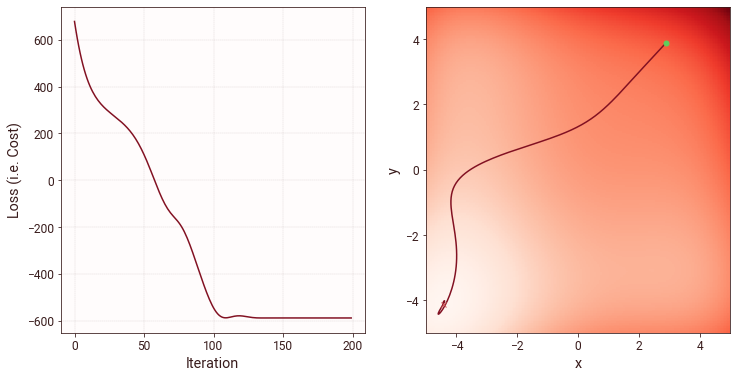

In [11]:
M = Model(initial_guess=[3,4])
optimizer = torch.optim.Adam(M.parameters(), lr=0.1)
losses, params = iteration(M, optimizer)

mesh = np.meshgrid(np.linspace(-5,5, num=200), np.linspace(-5,5, num=200))
surface = cost_function(mesh)
fig, axs = plt.subplots(1,2, figsize=(12,6))


axs[0].plot(losses)
axs[0].set_ylabel("Loss (i.e. Cost)")
axs[0].set_xlabel("Iteration")

axs[1].pcolormesh(*mesh, surface)
axs[1].plot(params[:,0], params[:,1], '-', label='Trajectory')
axs[1].plot(params[0,0], params[0,1], 'go')
axs[1].plot(params[-1,0], params[-1,1], 'rx')
axs[1].set_ylabel("y")
axs[1].set_xlabel("x")

fig.show()

100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2201.88it/s]
/home/kmills/anaconda3/envs/cim/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
100%|███████████████████████████████████████| 200/200 [00:00<00:00, 2189.68it/s]
/home/kmills/anaconda3/envs/cim/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
100%|███████████████████████████████████

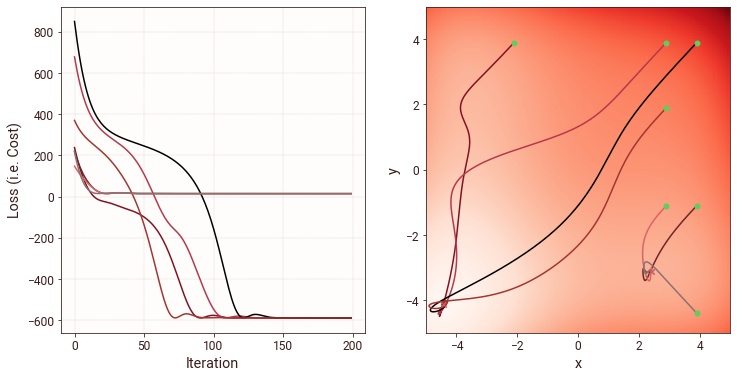

In [12]:
guesses = [[-2,4],[3,4],[4,4],[3,2],[4,-1],[3,-1],[4,-4.5]]

mesh = np.meshgrid(np.linspace(-5,5, num=200), np.linspace(-5,5, num=200))
surface = cost_function(mesh)
fig, axs = plt.subplots(1,2, figsize=(12,6))

for guess in guesses:

    M = Model(initial_guess=guess)
    optimizer = torch.optim.Adam(M.parameters(), lr=0.1)
    losses, params = iteration(M, optimizer)

    axs[0].plot(losses)
    axs[0].set_ylabel("Loss (i.e. Cost)")
    axs[0].set_xlabel("Iteration")

    axs[1].pcolormesh(*mesh, surface)
    axs[1].plot(params[:,0], params[:,1], '-', label='Trajectory')
    axs[1].plot(params[0,0], params[0,1], 'go')
    axs[1].plot(params[-1,0], params[-1,1], 'rx')
    axs[1].set_ylabel("y")
    axs[1].set_xlabel("x")
    
fig.show()
